In [2]:
from datetime import datetime
import re
import sys
sys.path.append('..')

import floc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed


sessions_fpath = '../data/comscore/2017/sessions.csv'

Find all bad domains, save to `output/bad_domains.txt`

In [3]:
bad_domains_fpath = '../output/bad_domains.txt'

In [105]:
domains_df = pd.read_csv(sessions_fpath, usecols=['domain_name'], encoding="ISO-8859-1")
domains = domains_df.domain_name.unique()

In [106]:
print('read in %s unique domains' % len(domains))

read in 4852018 unique domains


In [132]:
valid_hostname_regex = "^(([a-zA-Z0-9]|[a-zA-Z0-9][a-zA-Z0-9\-]*[a-zA-Z0-9])\.)*([A-Za-z0-9]|[A-Za-z0-9][A-Za-z0-9\-]*[A-Za-z0-9])$"
valid_hostname_pattern = re.compile(valid_hostname_regex)

def _is_bad_etld1_pattern(d):
    d = str(d)
    return False if ('.' in d and valid_hostname_pattern.fullmatch(d)) else True

def _is_bad_domain(domain):
    if _is_bad_etld1_pattern(str(domain)):
        return True
    try: 
        floc.hashes.sim_hash_string([domain])
        return False
    except Exception as e:
        return True
    
def get_bad_domains(domains):
    bad_domains = [d for d in domains if _is_bad_domain(d)]
    return bad_domains

In [110]:
bad_domains = get_bad_domains(domains)

print('writing %s bad domains to %s' % (len(bad_domains), bad_domains_fpath))
with open(bad_domains_fpath, 'w') as f:
    for domain in bad_domains:
        f.write(str(domain) + "\n")

writing 498004 bad domains to ../output/bad_domains.txt


In [111]:
bad_domains = []
with open(bad_domains_fpath, 'r') as f:
    for l in f.readlines():
        bad_domains.append(l.strip())
print('read %s bad domains from %s' % (len(bad_domains), bad_domains_fpath))

read 498004 bad domains from ../output/bad_domains.txt


---

## make pre-processed domains data for each machine, week

Read in sessions data, strip bad domains, format date correctly, and save to file

process in chunks

#### Make filter to keep / drop domains

Separate out the bad domains that look like eTLD+1's but that are not. 
These are the domains that cannot be quickly checked with a regex.

Making filter in this way that first checks if the domain matches a pattern and then checks if domain is in the smaller set of 'wellformed bad domains' that do have a valid pattern is WAY faster than checking each domain against list of all bad domains.

In [123]:
print('%s bad domains' % len(bad_domains))
bad_domains[:10]

498004 bad domains


['nan',
 'lcvvdqo',
 'cirqzrsgfi',
 'yahiyfxxfqk',
 'nnnlstzallxwl',
 'dwffhonlxjnkuv',
 'snapjsfzsphjzh',
 'mbalwtfeoqcyvnr',
 'ygkebjvdqqbsxj',
 'obje']

In [113]:
wellformed_bad_domains = [d for d in bad_domains if not _is_bad_etld1_pattern(d)]

In [114]:
print('%s wellformed bad domains' % len(wellformed_bad_domains))
wellformed_bad_domains[:10]

1304 wellformed bad domains


['mil.ar',
 'mn.it',
 'health.vn',
 'nv.us',
 'sc.ke',
 'dnsalias.com',
 'mil.ni',
 'gov.ec',
 'mi.th',
 'savona.it']

In [126]:
# Filter to keep domains
def keep_domain(d):
    return (not _is_bad_etld1_pattern(d)) and (not d in wellformed_bad_domains)

In [116]:
# make a map: {week: {machine_id: {set of domains from the week}}}
machine_ids = pd.read_csv(sessions_fpath, usecols=['machine_id'], encoding="ISO-8859-1").machine_id.unique()
weeks_machines_domains = {w: {machine_id: set() for machine_id in machine_ids} for w in range(1, 52+1)}

In [11]:
print('%s machine ids' % len(machine_ids))

93793 machine ids


In [119]:
jan1 = datetime.strptime(str('20170101'), '%Y%m%d')

In [127]:
CHUNKSIZE=1000000


def process_chunk(sessions_chunk):
    # drop rows with nan or malformed domains
    sessions_chunk.dropna(inplace=True)
    # drop malformed domains
    sessions_chunk = sessions_chunk[sessions_chunk.domain_name.map(keep_domain)]
    # drop rows where event date is Jan 1 2017.
    sessions_chunk = sessions_chunk[sessions_chunk.event_date > jan1]
    # assign weeks
    sessions_chunk['week'] = sessions_chunk.event_date.apply(lambda d: d.isocalendar()[1])
    # group by week, machine_id so that each row corresponds to list of unique
    # domains visited for given week for given machine
    week_machine_domains = sessions_chunk.groupby(
        ['week', 'machine_id']
    )['domain_name'].unique()
    return week_machine_domains


chunks = pd.read_csv(sessions_fpath, 
                     encoding="ISO-8859-1", 
                     chunksize=CHUNKSIZE, 
                     usecols=['machine_id', 'event_date', 'domain_name'],
                     parse_dates=['event_date'])

for i, chunk in enumerate(chunks):
    start_d = datetime.now()
    print('%s : chunk %s' % (start_d, i))
    week_machine_domains = process_chunk(chunk)
    for w in range(1, 52+1):
        # maps for week w, {machine_id -> [array of unique domains]}
        w_machine_domains_dict = week_machine_domains.xs(w).to_dict()
        for m, d_array in w_machine_domains_dict.items():
            weeks_machines_domains[w][m].update(set(d_array))
    print('time to handle chunk: %s' % (datetime.now() - start_d))


2021-12-07 18:07:48.044241 : chunk 0
time to handle chunk: 0:00:46.226161
2021-12-07 18:08:35.290825 : chunk 1
time to handle chunk: 0:02:58.101329
2021-12-07 18:11:34.444638 : chunk 2
time to handle chunk: 0:00:37.567284
2021-12-07 18:12:13.015798 : chunk 3
time to handle chunk: 0:00:40.306774
2021-12-07 18:12:54.329302 : chunk 4
time to handle chunk: 0:01:59.722084
2021-12-07 18:14:55.104358 : chunk 5
time to handle chunk: 0:00:45.944244
2021-12-07 18:15:42.101927 : chunk 6
time to handle chunk: 0:00:44.493653
2021-12-07 18:16:27.530737 : chunk 7
time to handle chunk: 0:02:02.831155
2021-12-07 18:18:31.334200 : chunk 8
time to handle chunk: 0:00:28.748619
2021-12-07 18:19:00.978074 : chunk 9
time to handle chunk: 0:00:29.957896
2021-12-07 18:19:31.888153 : chunk 10
time to handle chunk: 0:02:02.530292
2021-12-07 18:21:35.397033 : chunk 11
time to handle chunk: 0:00:29.473008
2021-12-07 18:22:05.781355 : chunk 12
time to handle chunk: 0:00:31.564007
2021-12-07 18:22:38.305235 : chunk 

time to handle chunk: 0:00:41.705664
2021-12-07 20:29:35.765631 : chunk 110
time to handle chunk: 0:00:39.563450
2021-12-07 20:30:16.599782 : chunk 111
time to handle chunk: 0:02:40.777289
2021-12-07 20:32:58.396319 : chunk 112
time to handle chunk: 0:00:33.346548
2021-12-07 20:33:32.665981 : chunk 113
time to handle chunk: 0:00:31.248416
2021-12-07 20:34:04.956673 : chunk 114
time to handle chunk: 0:02:29.088866
2021-12-07 20:36:35.023208 : chunk 115
time to handle chunk: 0:00:29.782576
2021-12-07 20:37:05.734717 : chunk 116
time to handle chunk: 0:00:36.932666
2021-12-07 20:37:43.622922 : chunk 117
time to handle chunk: 0:02:37.733345
2021-12-07 20:40:22.343351 : chunk 118
time to handle chunk: 0:00:34.467418
2021-12-07 20:40:57.739604 : chunk 119
time to handle chunk: 0:00:32.318967
2021-12-07 20:41:30.970139 : chunk 120
time to handle chunk: 0:02:30.567729
2021-12-07 20:44:02.492697 : chunk 121
time to handle chunk: 0:00:31.822674
2021-12-07 20:44:35.250900 : chunk 122
time to hand

In [128]:
weeks_machines_domains_df = pd.DataFrame({})
for w in range(1, 52+1):
    if w % 10 == 0:
        print('week', w, datetime.now().time())
    weeks_machines_domains_df = weeks_machines_domains_df.append(pd.DataFrame.from_dict(
        {m: [m, w, d, len(d)] for m,d in weeks_machines_domains[w].items()}, 
        orient='index', 
        columns=['machine_id', 'week','domains', 'n_domains']
    ))

week 10 21:24:06.278347
week 20 21:24:08.697728
week 30 21:24:11.624576
week 40 21:24:15.020631
week 50 21:25:54.953120


In [129]:
weeks_machines_domains_df.sort_values(
    'n_domains', ascending=False
).drop('machine_id', axis=1).head()

,week,domains,n_domains
227609563,7,"{bridgestonetire.ca, utharakalam.com, lovtradi...",150244
227609563,14,"{schmidtmachinery.com, zedezign.com, ecoforest...",146385
227609563,13,"{norakiraly.com, actualizarwhatsappgratis.com,...",130823
181325602,27,"{festivalstudios.tv, stranarazuma.ru, drafmedi...",96429
227609563,17,"{dnsmsn.com, old1415.cn, newburghpower.com, ba...",92748


#### Save to file and reread from file.

The domains set is encoded as a string for easier file read/writes.

In [5]:
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'

def write_weeks_machines_domains(df):
    df['domains_str'] = df.domains.apply(lambda x: "|".join(x))
    print('saving %s rows to file %s...' % (len(df), weeks_machines_domains_fpath))
    df.drop('domains', axis=1).to_csv(weeks_machines_domains_fpath, index=False)
    print('...saved')
    
def read_weeks_machines_domains(nrows=None):
    print('reading from %s...' % weeks_machines_domains_fpath)
    df = pd.read_csv(weeks_machines_domains_fpath, nrows=nrows)
    df['domains'] = df.domains_str.fillna('').apply(lambda x: set(x.split('|')) if x else set())
    df.drop('domains_str', axis=1, inplace=True)
    print('... read %s rows' % len(df))
    return df

In [131]:
write_weeks_machines_domains(weeks_machines_domains_df)

saving 4877236 rows to file ../output/weeks_machines_domains.csv...
...saved


### Re-entry point

Read from file

In [6]:
weeks_machines_domains_df = read_weeks_machines_domains()
weeks_machines_domains_df.drop('machine_id', axis=1).head()

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


,week,n_domains,domains
0,1,104,"{guim.co.uk, tomshardware.com, watchonlinecart..."
1,1,0,{}
2,1,20,"{sammsoft.com, safeway.com, snagajob.com, shei..."
3,1,49,"{online-tech-tips.com, jjgirls.com, jenysmith...."
4,1,64,"{coupons.com, 247-inc.net, espn.com, scottrade..."


black dashed line for 7 domains


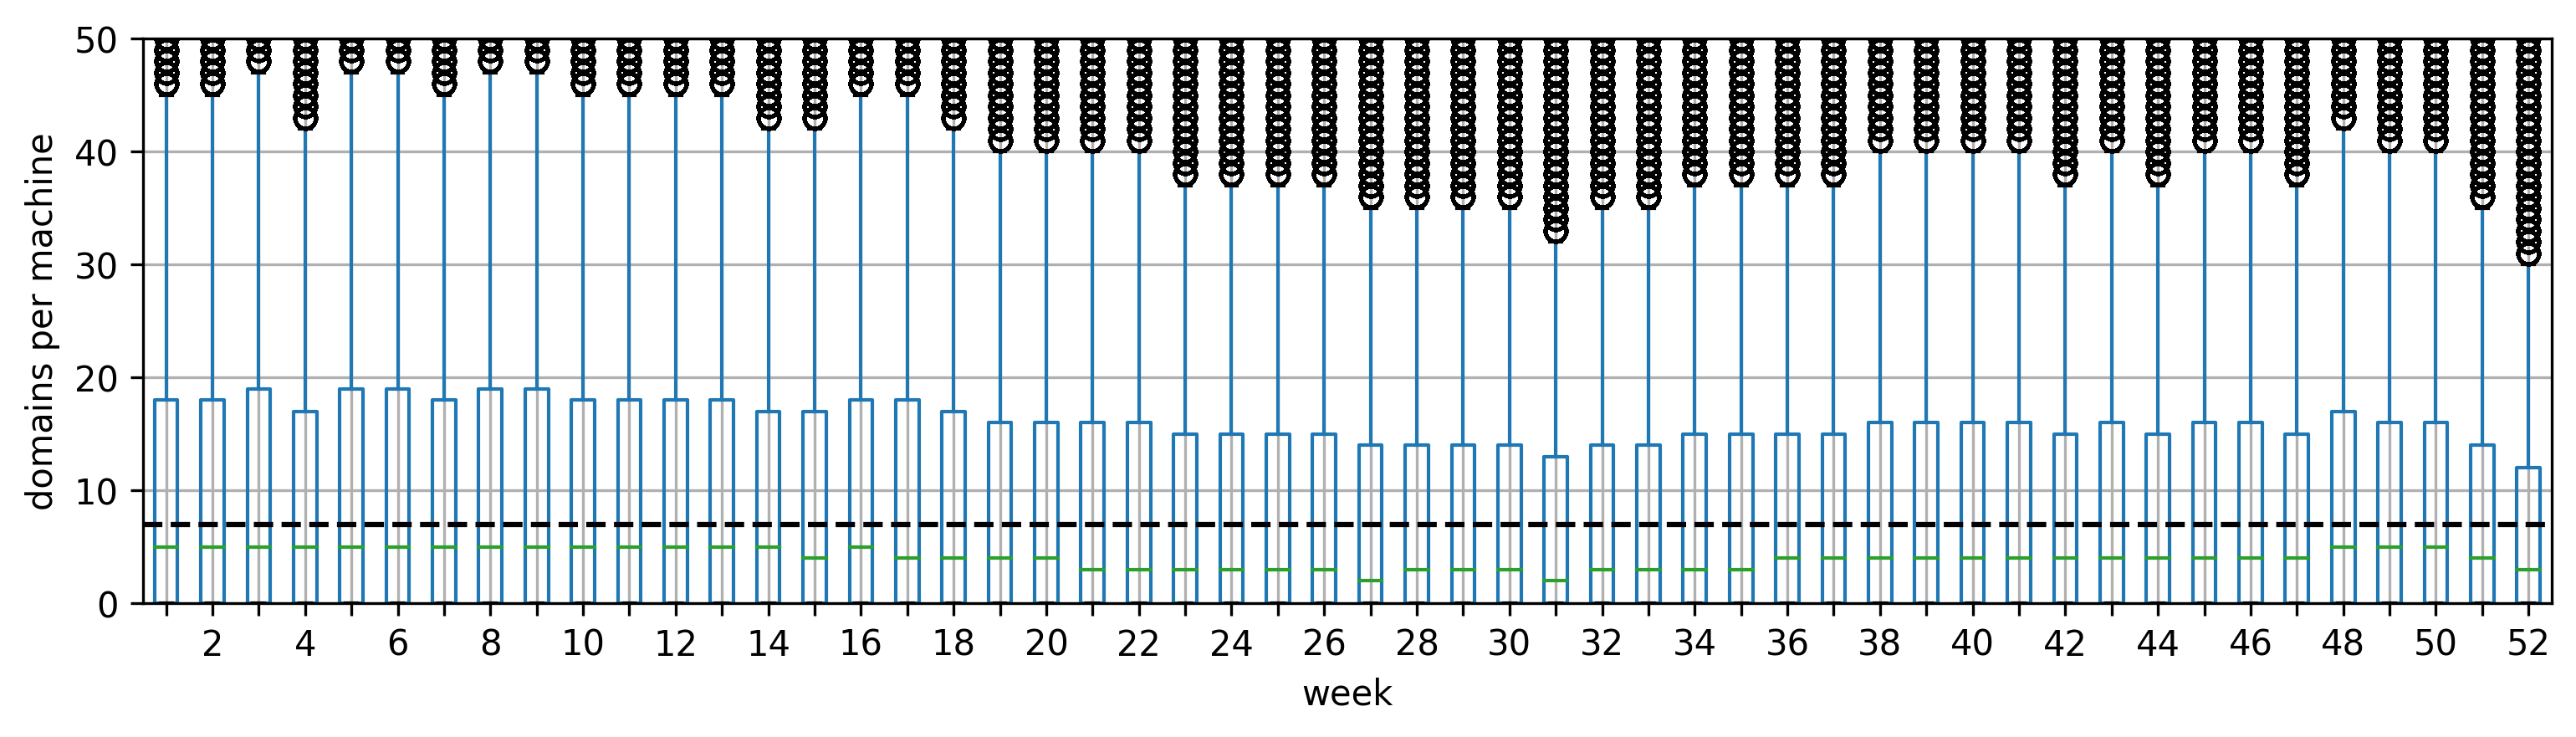

In [28]:
# basic stats
weeks_machines_domains_df['n_domains'].describe()

# show box plot without extreme outliers
dpi=300 # 150
fig, ax = plt.subplots(figsize=(12, 3), dpi=dpi)
weeks_machines_domains_df.boxplot(column=['n_domains'], by='week', ax=ax)
ax.set_ylabel('domains per machine')
fig.suptitle('')
ax.axhline(y=7, linestyle='--', color='black', label='7 domains')
ax.set_ylim(0, 50) # exclude showing large outliers
print('black dashed line for 7 domains')
_ = ax.set_xticklabels(['' if i%2 != 0 else i for i in range(1,53)])
# title = 'boxplot : domains per machine grouped by week'
title = ''
_ = ax.set_title(title)